# EDA of the self driving dataset

---

Łukasz Borak 156043

## Loading and transforming the dataset

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [34]:
filepaths = os.listdir('dataset')
filepaths

['1653043549.5187616.csv',
 '1652959347.972946.csv',
 '1653043428.8546412.csv',
 '1652959186.4507334.csv',
 '1652875901.3107166.csv',
 '1652876206.2541456.csv',
 '1652876485.8123376',
 '1653042775.5213027.csv',
 '1652875851.3497071.csv',
 '1653043428.8546412',
 '1652876485.8123376.csv',
 '1653043202.5073502.csv',
 '1653042695.4914637',
 '1652875901.3107166',
 '1652959347.972946',
 '1653042775.5213027',
 '1653043202.5073502',
 '1652875851.3497071',
 '1653043549.5187616',
 '1652876013.741493',
 '1653043345.3415065',
 '1652959186.4507334',
 '1653043345.3415065.csv',
 '1653042695.4914637.csv',
 '1652876206.2541456',
 '1652876013.741493.csv']

In [35]:
csv_filepaths = [path for path in filepaths if path.endswith('.csv')]
csv_filepaths

['1653043549.5187616.csv',
 '1652959347.972946.csv',
 '1653043428.8546412.csv',
 '1652959186.4507334.csv',
 '1652875901.3107166.csv',
 '1652876206.2541456.csv',
 '1653042775.5213027.csv',
 '1652875851.3497071.csv',
 '1652876485.8123376.csv',
 '1653043202.5073502.csv',
 '1653043345.3415065.csv',
 '1653042695.4914637.csv',
 '1652876013.741493.csv']

In [36]:
dataframes = []
for filepath in csv_filepaths:
    df = pd.read_csv(
        os.path.join('dataset', filepath),
        names = ['image_number', 'forward_signal', 'left_signal']
    )
    df.insert(0, 'image_path', filepath[:-4])
    df['image_path'] = df.apply(
        lambda x: x['image_path'] + '/' + ('000' + str(x['image_number']))[-4:] + '.jpg',
        axis=1,
    )
    #print(df.head())
    #print(df.columns)
    #print(df.describe())
    #print(df.info())
    dataframes.append(df)

In [37]:
data = pd.concat(dataframes, axis=0)
data.head()

image_path  image_number  forward_signal  left_signal
0  1653043549.5187616/0045.jpg            45        0.203125          0.0
1  1653043549.5187616/0046.jpg            46        0.234375          0.0
2  1653043549.5187616/0047.jpg            47        0.304688          0.0
3  1653043549.5187616/0048.jpg            48        0.617188          0.0
4  1653043549.5187616/0049.jpg            49        0.656250          0.0

### Let's see if we can read some images

1653043549.5187616/0045.jpg 0.203125 0.0


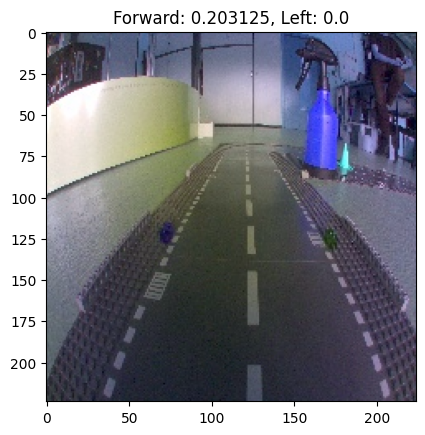

1653043549.5187616/0046.jpg 0.234375 0.0


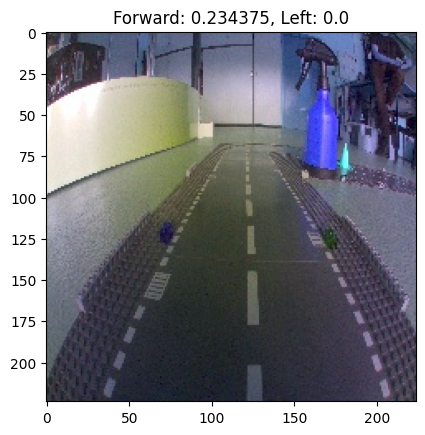

In [38]:
for i in range(2):
    image_path = data.iloc[i]['image_path']
    forward_signal = data.iloc[i]['forward_signal']
    left_signal = data.iloc[i]['left_signal']
    print(image_path, forward_signal, left_signal)
    image = cv2.imread(os.path.join('dataset', image_path))
    plt.imshow(image)
    plt.title(f'Forward: {forward_signal}, Left: {left_signal}')
    plt.show()

## Preprocessing pipeline

In [39]:
paths = data['image_path'].to_numpy()
fw = torch.tensor(
    data['forward_signal'].to_numpy(), 
    dtype=torch.float32
)
lt = torch.tensor(
    data['left_signal'].to_numpy(), 
    dtype=torch.float32
)

train_paths, val_paths, train_fw, val_fw, train_lt, val_lt = train_test_split(
    paths, fw, lt,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [40]:
add_noise = v2.Lambda(lambda img: img + torch.randn_like(img) * 0.02)

train_transforms = v2.Compose([
    #v2.RandomResizedCrop(
    #    size=(224, 224),
    #    scale=(0.9, 1.0),
    #    ratio=(3/4, 4/3)
    #),
    v2.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.01
    ),
    #v2.RandomPerspective(
    #    distortion_scale=0.1,
    #    p=0.5
    #),
    v2.RandomApply(
        transforms=[v2.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0))],
        p=0.3
    ),
    v2.ToTensor(),
    #v2.RandomErasing(
    #    p=0.5,
    #    scale=(0.02, 0.1),
    #    ratio=(0.3, 3.3),
    #),
    v2.RandomApply([add_noise], p=0.5),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
])

/home/milte/Desktop/jetbot/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [41]:
class JetBotDataset(Dataset):
    def __init__(self, images, forward_signals, left_signals, transform=None):
        self.images = images
        self.forward_signals = forward_signals
        self.left_signals = left_signals
        self.transforms = transform
        
        self.cache = {}

    
    def __len__(self):
        return len(self.images)

   
    def __getitem__(self, idx):
        if idx in self.cache:
            image,label = self.cache[idx]
        else:
            image = Image.open(os.path.join('dataset', self.images[idx])).convert('RGB')
            forward_signal = self.forward_signals[idx]
            left_signal = self.left_signals[idx]
            label = torch.stack([forward_signal, left_signal], dim=0)
            self.cache[idx] = (image,label)
        
        image = self.transforms(image)
        return image, label


train_ds = JetBotDataset(
    train_paths,
    train_fw,
    train_lt,
    transform=train_transforms
)
val_ds = JetBotDataset(
    val_paths,
    val_fw,
    val_lt,
    transform=val_transforms
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

Length of dataset: 6067
Length of dataloader: 190
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Forward signal shape: torch.Size([32])
Left signal shape: torch.Size([32])


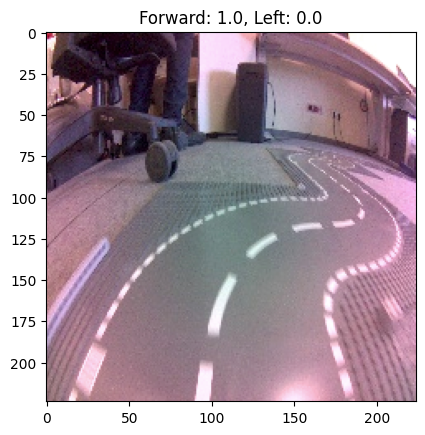

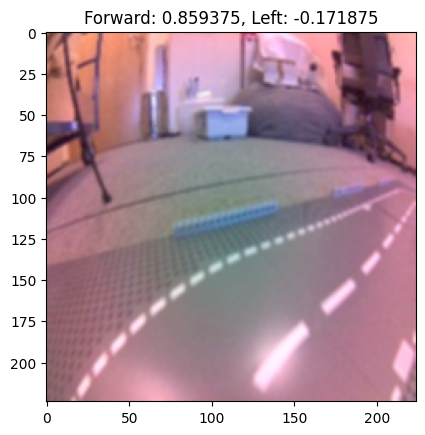

In [42]:
print(f'Length of dataset: {len(train_ds)}')
print(f'Length of dataloader: {len(train_loader)}')

for images, labels in train_loader:
    fwd_sig = labels[:, 0]
    left_sig = labels[:, 1]
    print(f'Batch size: {images.size(0)}')
    print(f'Image shape: {images.shape}')
    print(f'Forward signal shape: {fwd_sig.shape}')
    print(f'Left signal shape: {left_sig.shape}')
    break

for i in range(2):
    image, (forward_signal, left_signal) = train_ds[i]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f'Forward: {forward_signal}, Left: {left_signal}')
    plt.show()

Length of dataset: 1517
Length of dataloader: 48
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Forward signal shape: torch.Size([32])
Left signal shape: torch.Size([32])


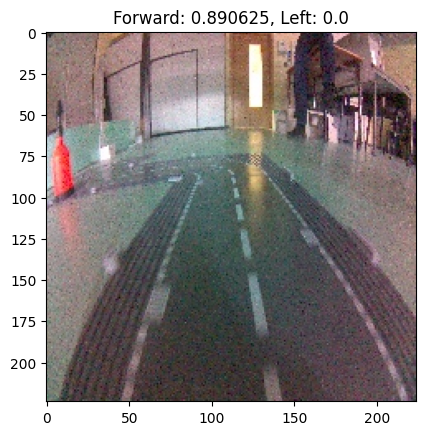

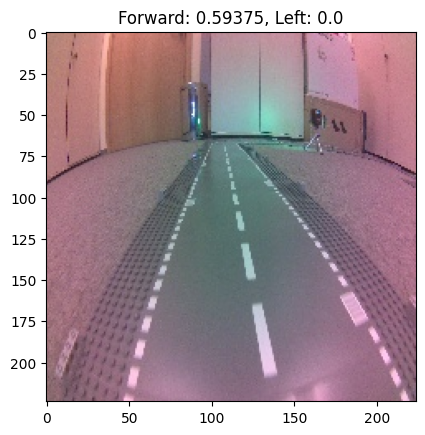

In [45]:
print(f'Length of dataset: {len(val_ds)}')
print(f'Length of dataloader: {len(val_loader)}')

for images, labels in val_loader:
    fwd_sig = labels[:, 0]
    left_sig = labels[:, 1]
    print(f'Batch size: {images.size(0)}')
    print(f'Image shape: {images.shape}')
    print(f'Forward signal shape: {fwd_sig.shape}')
    print(f'Left signal shape: {left_sig.shape}')
    break

for i in range(2):
    image, (forward_signal, left_signal) = val_ds[i]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f'Forward: {forward_signal}, Left: {left_signal}')
    plt.show()

## Model experimentation

The goal is to build a CNN-based model that outputs predictions for 2 continuous values - forward and left.

In [47]:
class weighted_MSELoss(nn.Module):
    def __init__(self,weights):
        super().__init__()
        self.weight = torch.tensor(weights,dtype=torch.float32).to(device)
        
    def forward(self,inputs,target):
        return torch.mean(((inputs - target)**2 ) * self.weight)
    
class SimpleCNN(nn.Module):
    def __init__(self, num_outputs=2):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(2),
            nn.Flatten(),
            nn.Linear(256*4,128),
            nn.ReLU(),
            nn.Linear(128,num_outputs),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.net(x)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_outputs=2).to(device)
criterion = weighted_MSELoss([0.3,0.7])#nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_weights = []
val_losses = []

step_down_mult = 0.5
no_improv_window = 3

no_improv = 0

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    i = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # labels: [B,2]

        optimizer.zero_grad()
        outputs = model(images)        # [B,2]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        print(i,end='\r')
        i+=1
        

    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    if len(val_losses) > 0 and avg_val_loss >= min(val_losses):
        no_improv += 1
    else:
        no_improv = 0
    
    if no_improv > no_improv_window:
        for g in optimizer.param_groups:
            g['lr'] *= step_down_mult
            print(g['lr'])
        no_improv -= 1
        
    val_losses.append(avg_val_loss)
    model_weights.append(model.state_dict().copy())
    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train MSE: {avg_train_loss:.4f}, "
          f"Val MSE:   {avg_val_loss:.4f}")

Epoch 1/20 — Train MSE: 0.0981, Val MSE:   0.0753
Epoch 2/20 — Train MSE: 0.0671, Val MSE:   0.0612
Epoch 3/20 — Train MSE: 0.0599, Val MSE:   0.0607
Epoch 4/20 — Train MSE: 0.0572, Val MSE:   0.0616
Epoch 5/20 — Train MSE: 0.0544, Val MSE:   0.0559
Epoch 6/20 — Train MSE: 0.0520, Val MSE:   0.0543
Epoch 7/20 — Train MSE: 0.0500, Val MSE:   0.0515
Epoch 8/20 — Train MSE: 0.0488, Val MSE:   0.0529
Epoch 9/20 — Train MSE: 0.0477, Val MSE:   0.0576
Epoch 10/20 — Train MSE: 0.0465, Val MSE:   0.0534
Epoch 11/20 — Train MSE: 0.0454, Val MSE:   0.0504
Epoch 12/20 — Train MSE: 0.0438, Val MSE:   0.0501
Epoch 13/20 — Train MSE: 0.0424, Val MSE:   0.0494
Epoch 14/20 — Train MSE: 0.0422, Val MSE:   0.0806
Epoch 15/20 — Train MSE: 0.0410, Val MSE:   0.0486
Epoch 16/20 — Train MSE: 0.0408, Val MSE:   0.0458
Epoch 17/20 — Train MSE: 0.0401, Val MSE:   0.0531
Epoch 18/20 — Train MSE: 0.0387, Val MSE:   0.0521
Epoch 19/20 — Train MSE: 0.0375, Val MSE:   0.0687
0.0005
Epoch 20/20 — Train MSE: 0.0369, 

In [48]:
min_idx = np.argmin(val_losses)
print(f"loading best model state from epoch {min_idx + 1}")
model.load_state_dict(model_weights[min_idx])

loading best model state from epoch 16


<All keys matched successfully>

## Saving the model and exporting to ONNX

In [49]:
example_inputs = (torch.randn(1, 3, 224, 224),)
onnx_program = torch.onnx.export(model.to('cpu'), example_inputs,"test.onnx", export_params=True, opset_version=11, do_constant_folding=True, input_names=['input'],output_names=['output'])


In [50]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

289570

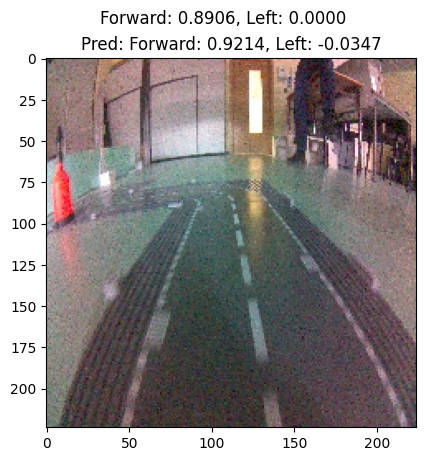

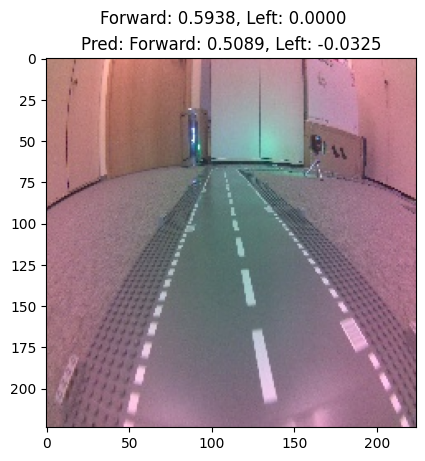

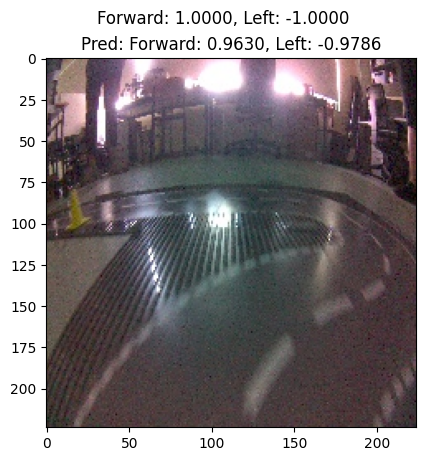

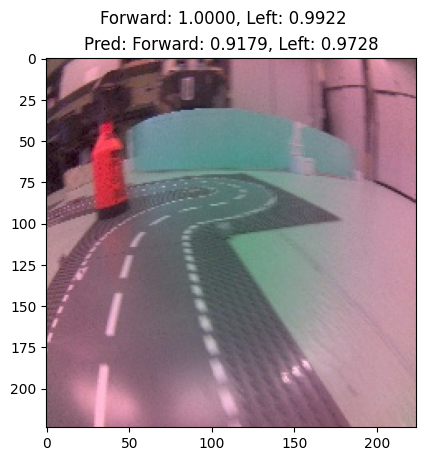

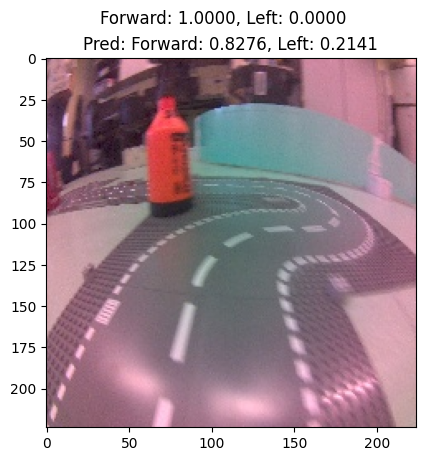

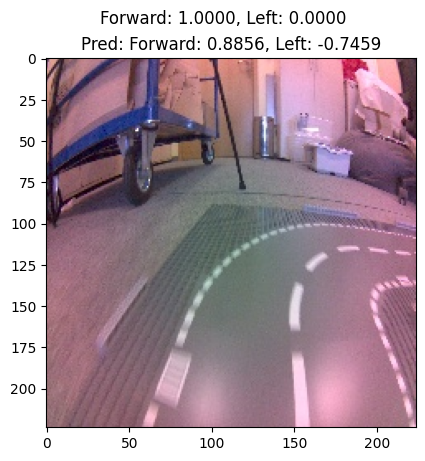

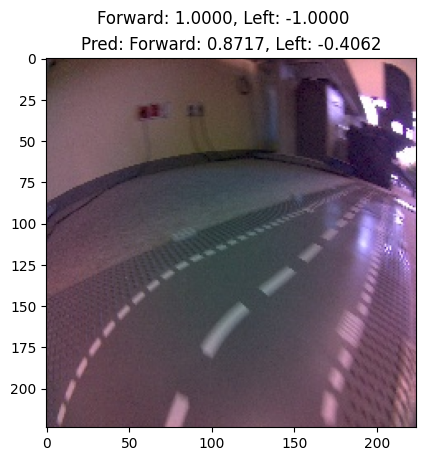

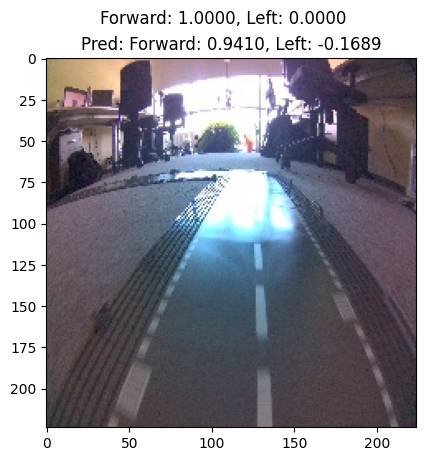

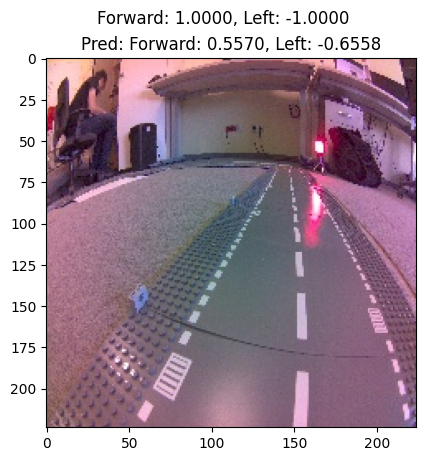

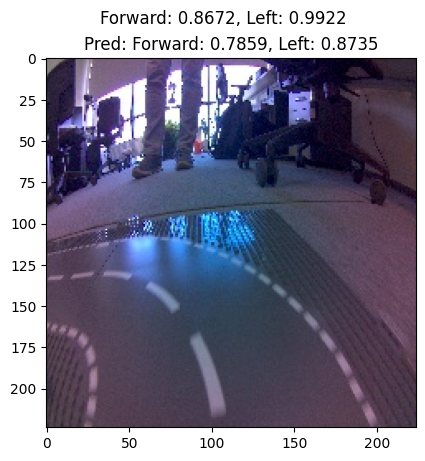

In [51]:
for i in range(10):
    image, (forward_signal, left_signal) = val_ds[i]
    out = model(image[None,...]).detach().cpu().numpy()[0]
    image = image.permute(1, 2, 0).numpy()
    
    #print(out)
    plt.imshow(image)
    plt.suptitle(f'Forward: {forward_signal:.4f}, Left: {left_signal:.4f}')
    plt.title(f'Pred: Forward: {out[0]:.4f}, Left: {out[1]:.4f}')
    plt.show()